<a href="https://colab.research.google.com/github/cartman12/DS-Unit-2-Regression-1/blob/master/module3-random-forests/Mohamad%20Ali%20Nasser%20-%20Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install category_encoders
!pip install pandas==0.23.4
!pip install graphviz
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [104]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

pd.set_option('display.float_format', '{:.2f}'.format)

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('https://drive.google.com/uc?export=download&id=14ULvX0uOgftTB2s97uS8lIx1nHGQIB0P'), 
                 pd.read_csv('https://drive.google.com/uc?export=download&id=1r441wLr7gKGHGLyPpKauvCuUOU556S2f'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1wvsYl9hbRbZuIuoaLWCsW_kbcxCdocHz')
sample_submission = pd.read_csv('https://drive.google.com/uc?export=download&id=1kfJewnmhowpUo381oSn3XqsQ6Eto23XV')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

# Print dataframe shapes
print('train', train.shape)
print('val', val.shape)
print('test', test.shape)

train (47520, 41)
val (11880, 41)
test (14358, 40)


In [106]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
        region = list(X['region'].unique())   
    for cols in ['longitude', 'latitude','population']:
      for i in region: 
        mean = X.loc[X['region'] == i, cols].mean() 
        X.loc[X['region'] == i, cols] = X.loc[X['region'] == i, cols].fillna(mean)
      
    
#     for col in cols_with_zeros:
#          X[col + '_IS_MISSING'] = X[col].isnull().astype(int)
        
    # For categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
#     X['population'] = X['population'].replace(0, np.nan)
#     X['population'] = X['population'].fillna(X['population'].median())
    
    truelist = [True]
    falselist = [False]
    truelist = int(X['public_meeting'].value_counts(normalize=True)[1]*100) * [True]
    falselist = int(X['public_meeting'].value_counts(normalize=True)[0]*100) * [False]
    true_false_list = falselist + truelist
    X['public_meeting'] = X['public_meeting'].replace('MISSING', np.random.choice(true_false_list))

    truelist2 = [True]
    falselist2 = [False]
    truelist2 = int(X['permit'].value_counts(normalize=True)[1]*100) * [True]
    falselist2 = int(X['permit'].value_counts(normalize=True)[0]*100) * [False]
    true_false_list2 = falselist2 + truelist2
    X['permit'] = X['permit'].replace('MISSING', np.random.choice(true_false_list2))
    newlist = train2['water_quality'].value_counts(normalize=True).index.tolist()
    newlist.remove('unknown')
    
    listy = []
    for i in range(len(newlist)):
      softlist = int(X['water_quality'].value_counts(normalize=True)[newlist][i]*10000) * [newlist[i]]

      listy.extend(softlist)
    X['water_quality'] = X['water_quality'].replace('unkown', np.random.choice(listy))
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)


KeyError: ignored

In [0]:
categorical_features = ['basin',
 'region',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'extraction_type',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source_type',
 'waterpoint_type']

In [0]:
categorical_features = ['public_meeting', 'management', 'payment', 'waterpoint_type',
 'permit',
 'quantity',
 'payment_type',
 'source_type',
 'water_quality',
 'basin',
 'extraction_type','installer','ward','lga','subvillage','basin','funder']
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
# numeric_features = train_features.select_dtypes(include='number').columns.tolist()
numeric_features = ['amount_tsh', 'latitude','longitude',
 'gps_height', 'region_code']

#cardinality_list = [x for x in train_features.select_dtypes(exclude='number').columns.tolist() if x not in categorical_features]

# Get a series with the cardinality of the nonnumeric features
#cardinality = train_features[categorical_features].select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
#categorical_features = cardinality[cardinality <= 50].index.tolist()

features = numeric_features + categorical_features

In [0]:
numeric_features

['amount_tsh', 'latitude', 'longitude', 'gps_height', 'region_code']

In [0]:
features

['amount_tsh',
 'latitude',
 'longitude',
 'gps_height',
 'region_code',
 'public_meeting',
 'management',
 'payment',
 'waterpoint_type',
 'permit',
 'quantity',
 'payment_type',
 'source_type',
 'water_quality',
 'basin',
 'extraction_type',
 'basin']

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
cardinality

date_recorded              349
funder                    1717
installer                 1930
wpt_name                 30661
basin                        9
subvillage               17232
region                      21
lga                        124
ward                      2082
public_meeting               3
recorded_by                  1
scheme_management           13
scheme_name               2564
permit                       3
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

In [0]:
cardinality

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
categorical_features = [
 'region',
 'public_meeting',
 'permit',
 'extraction_type',
 'management',
 'water_quality',
 'quantity',
 'source_type',
 'waterpoint_type']
numeric_features = ['amount_tsh', 'latitude','longitude','population','construction_year','year_recorded','district_code','gps_height']
features = numeric_features + categorical_features


In [0]:
X_train.head()

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [0]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42, max_depth = 20)
model.fit(X_train_encoded, y_train)
print('Decision Tree')
print('Train Accuracy', model.score(X_train_encoded, y_train))
print('Validation Accuracy', model.score(X_val_encoded, y_val))

Decision Tree
Train Accuracy 0.8854587542087542
Validation Accuracy 0.7677609427609428


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
model = RandomForestClassifier(n_estimators = 442, random_state=42, max_depth = 23)
model.fit(X_train_encoded, y_train)
print('RandomForest')
print('Train Accuracy', model.score(X_train_encoded, y_train))
print('Validation Accuracy', model.score(X_val_encoded, y_val))

RandomForest
Train Accuracy 0.9513257575757575
Validation Accuracy 0.8121212121212121


In [0]:
y_pred = model.predict(X_test_encoded)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-forest-4.csv', index=False)

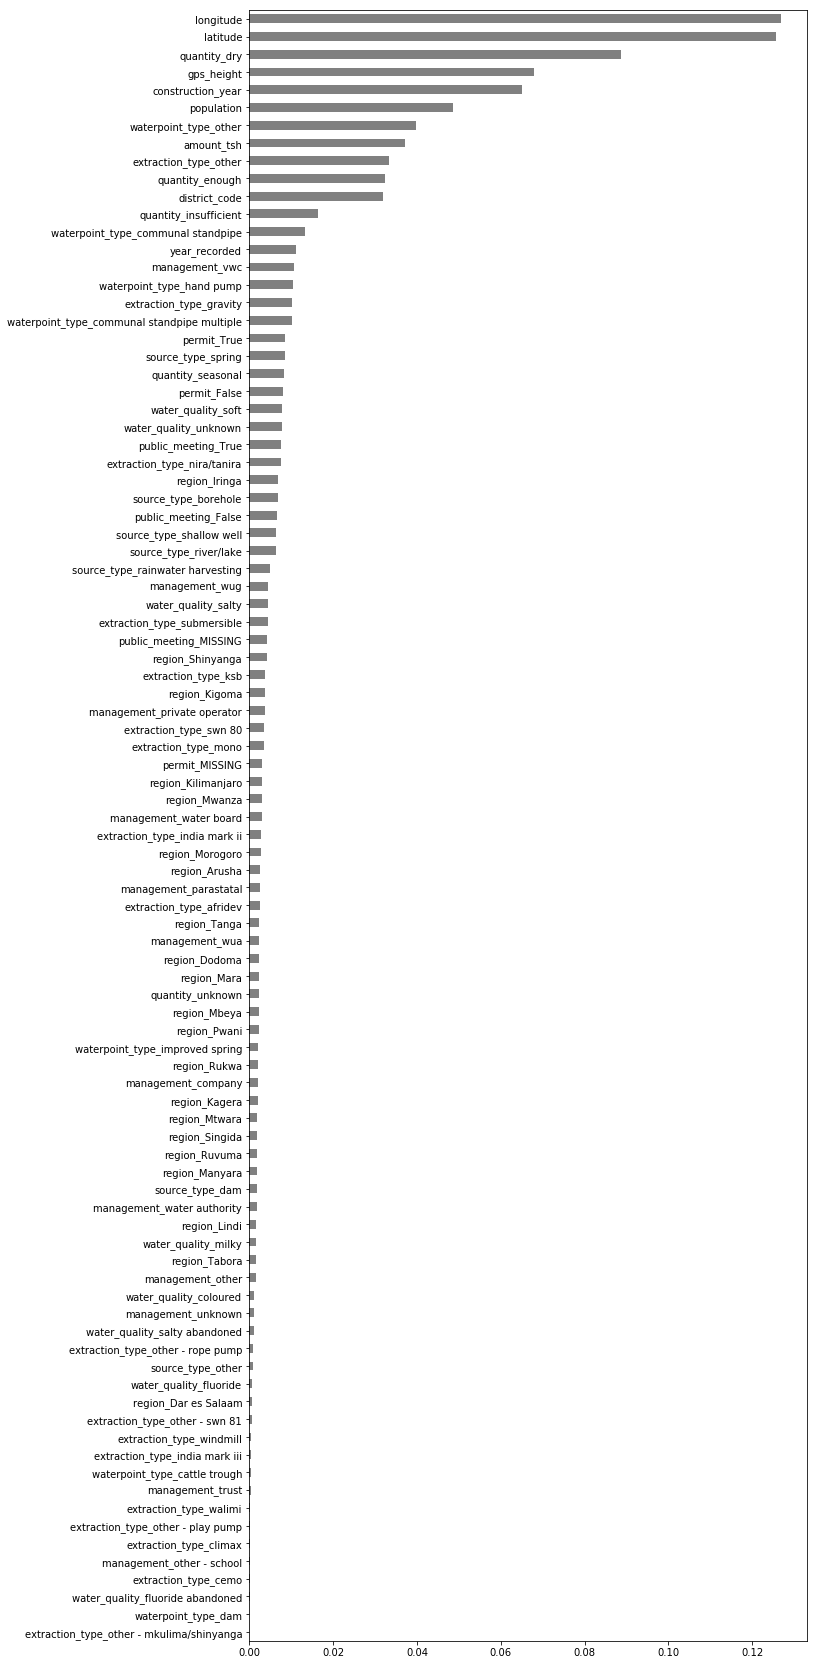

In [0]:
importances = pd.Series(model.feature_importances_, 
                        X_train_encoded.columns)

plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [0]:
from sklearn.ensemble import ExtraTreesClassifier

In [0]:
model = ExtraTreesClassifier(n_estimators = 400, random_state=42)
model.fit(X_train_encoded, y_train)
print('ExtraTreesClassifier')
print('Train Accuracy', model.score(X_train_encoded, y_train))
print('Validation Accuracy', model.score(X_val_encoded, y_val))

ExtraTreesClassifier
Train Accuracy 0.9953914141414142
Validation Accuracy 0.7902356902356902


In [0]:
y_pred = model.predict(X_test_scaled)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv', index=False)

In [0]:
importances = pd.Series(model.feature_importances_, 
                        X_train_encoded.columns)

In [0]:
new_features = importances.sort_values(ascending = False)
new_features = importances[:70]

In [0]:
new_features = list(new_features.index)

In [0]:
# Arrange data into X new_features matrix and y target vector 
X_train = train[new_features]
y_train = train[target]
X_val = val[new_features]
y_val = val[target]
X_test = test[new_features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [0]:
train2 = train.copy()

In [0]:
truelist = [True]
falselist = [False]

In [0]:
truelist = int(train2['public_meeting'].value_counts(normalize=True)[1]*100) * [True]
falselist = int(train2['public_meeting'].value_counts(normalize=True)[0]*100) * [False]
true_false_list = falselist + truelist

In [0]:
true_false_list

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [0]:
train2['public_meeting'] = train2['public_meeting'].replace('MISSING', np.random.choice(true_false_list))

In [0]:
val2 = val.copy()
truelist = [True]
falselist = [False]
truelist = int(val2['public_meeting'].value_counts(normalize=True)[1]*100) * [True]
falselist = int(val2['public_meeting'].value_counts(normalize=True)[0]*100) * [False]
true_false_list = falselist + truelist
val2['public_meeting'] = val2['public_meeting'].replace('MISSING', np.random.choice(true_false_list))

In [0]:
test2 = test.copy()
truelist = [True]
falselist = [False]
truelist = int(test2['public_meeting'].value_counts(normalize=True)[1]*100) * [True]
falselist = int(test2['public_meeting'].value_counts(normalize=True)[0]*100) * [False]
true_false_list = falselist + truelist
test2['public_meeting'] = test2['public_meeting'].replace('MISSING', np.random.choice(true_false_list))

In [0]:
truelist = [True]
falselist = [False]
truelist = int(train2['permit'].value_counts(normalize=True)[1]*100) * [True]
falselist = int(train2['permit'].value_counts(normalize=True)[0]*100) * [False]
true_false_list = falselist + truelist
train2['permit'] = train2['permit'].replace('MISSING', np.random.choice(true_false_list))

In [0]:
truelist = [True]
falselist = [False]
truelist = int(val2['permit'].value_counts(normalize=True)[1]*100) * [True]
falselist = int(val2['permit'].value_counts(normalize=True)[0]*100) * [False]
true_false_list = falselist + truelist
val2['permit'] = val2['permit'].replace('MISSING', np.random.choice(true_false_list))

In [0]:
truelist = [True]
falselist = [False]
truelist = int(test2['permit'].value_counts(normalize=True)[1]*100) * [True]
falselist = int(test2['permit'].value_counts(normalize=True)[0]*100) * [False]
true_false_list = falselist + truelist
test2['permit'] = test2['permit'].replace('MISSING', np.random.choice(true_false_list))

In [0]:
def missing(X,feature1, feature2):
  X2 = X.copy()
  truelist = [True]
  falselist = [False]
  truelist = int(X2[feature1].value_counts(normalize=True)[1]*100) * [True]
  falselist = int(X2[feature1].value_counts(normalize=True)[0]*100) * [False]
  true_false_list = falselist + truelist
  X2[feature1] = X2[feature1].replace('MISSING', np.random.choice(true_false_list))
  
  truelist2 = [True]
  falselist2 = [False]
  truelist2 = int(X2[feature2].value_counts(normalize=True)[1]*100) * [True]
  falselist2 = int(X2[feature2].value_counts(normalize=True)[0]*100) * [False]
  true_false_list2 = falselist2 + truelist2
  X2[feature2] = X2[feature2].replace('MISSING', np.random.choice(true_false_list2))
  return X2

train2 = missing(train, 'public_meeting','permit')
val2 = missing(val, 'public_meeting','permit')
test2 = missing(test, 'public_meeting','permit')
  

In [0]:
newlist = train2['water_quality'].value_counts(normalize=True).index.tolist()

In [0]:
newlist.remove('unknown')

In [0]:
newlist

['soft',
 'salty',
 'milky',
 'coloured',
 'salty abandoned',
 'fluoride',
 'fluoride abandoned']

In [0]:
train2['water_quality'].isna()

In [0]:
newlist[0]

'soft'

In [0]:
def water(X):
  
  listy = []
  for i in range(len(newlist)):
    softlist = int(X['water_quality'].value_counts(normalize=True)[newlist][i]*10000) * [newlist[i]]
    
    listy.extend(softlist)
  X['water_quality'] = X['water_quality'].replace('unkown', np.random.choice(listy))
  return X


In [0]:
def year(X):
  X['construction_year'] = X['construction_year'].astype(int)
  X['years_since_c'] = X['construction_year'] - X['year_recorded']
  return X

In [0]:
train2 = water(train2)
test2 = water(test2)
val2 = water(val2)

In [0]:
train2 = year(train2)
test2 = year(test2)
val2 = year(val2)

In [0]:
def population(X):
  X['population'] = X['population'].replace(0, np.nan)
  X['population'] = X['population'].fillna(X['population'].median())
  return X

In [0]:
train2['population'].describe()

count   47520.00
mean      179.81
std       463.08
min         0.00
25%         0.00
50%        25.00
75%       215.00
max     15300.00
Name: population, dtype: float64

In [0]:
train2 = population(train2)
test2 = population(test2)
val2 = population(val2)

In [0]:
from mpl_toolkits import mplot3d

%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
train2['population'].shape, ce.OrdinalEncoder().fit_transform(train['status_group']).shape

((47520,), (47520, 1))

In [0]:
train['status_group'].value_counts()

functional                 25807
non functional             18259
functional needs repair     3454
Name: status_group, dtype: int64

In [0]:
ce.OrdinalEncoder().fit_transform(train['status_group']).head()

,status_group
43360,1
7263,1
2486,1
313,2
52726,1


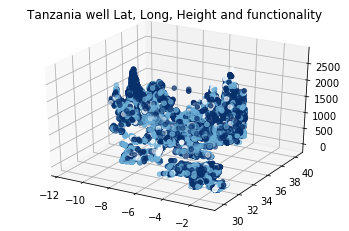

<Figure size 720x2160 with 0 Axes>

In [0]:
ax = plt.axes(projection='3d')



# Data for three-dimensional scattered points
zdata = train['gps_height']
xdata = train['latitude']
ydata = train['longitude']
ax.scatter3D(xdata, ydata, zdata, c=ce.OrdinalEncoder().fit_transform(train['status_group'])['status_group'], cmap='Blues_r');
plt.title('Tanzania well Lat, Long, Height and functionality')
plt.figure(figsize=(10,30));



In [0]:
categorical_features = [
 'region',
 'public_meeting',
 'permit',
 'extraction_type',
 'management',
 'water_quality',
 'quantity',
 'source_type',
 'waterpoint_type']
numeric_features = ['amount_tsh', 'latitude','longitude','population','construction_year','district_code','gps_height','years_since_c']
target = 'status_group'
features = numeric_features + categorical_features

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train2[features]
y_train = train2[target]
X_val = val2[features]
y_val = val2[target]
X_test = test2[features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
model = RandomForestClassifier(n_estimators = 446, random_state=42, max_depth = 23)
model.fit(X_train_encoded, y_train)
print('RandomForest')
print('Train Accuracy', model.score(X_train_encoded, y_train))
print('Validation Accuracy', model.score(X_val_encoded, y_val))

RandomForest
Train Accuracy 0.9508627946127947
Validation Accuracy 0.8093434343434344


In [0]:
print('RandomForest')
print('Train Accuracy', model.score(X_train_encoded, y_train))
print('Validation Accuracy', model.score(X_val_encoded, y_val))

RandomForest
Train Accuracy 0.9508627946127947
Validation Accuracy 0.8093434343434344


In [0]:
y_pred = model.predict(X_test_encoded)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-forest-10.csv', index=False)

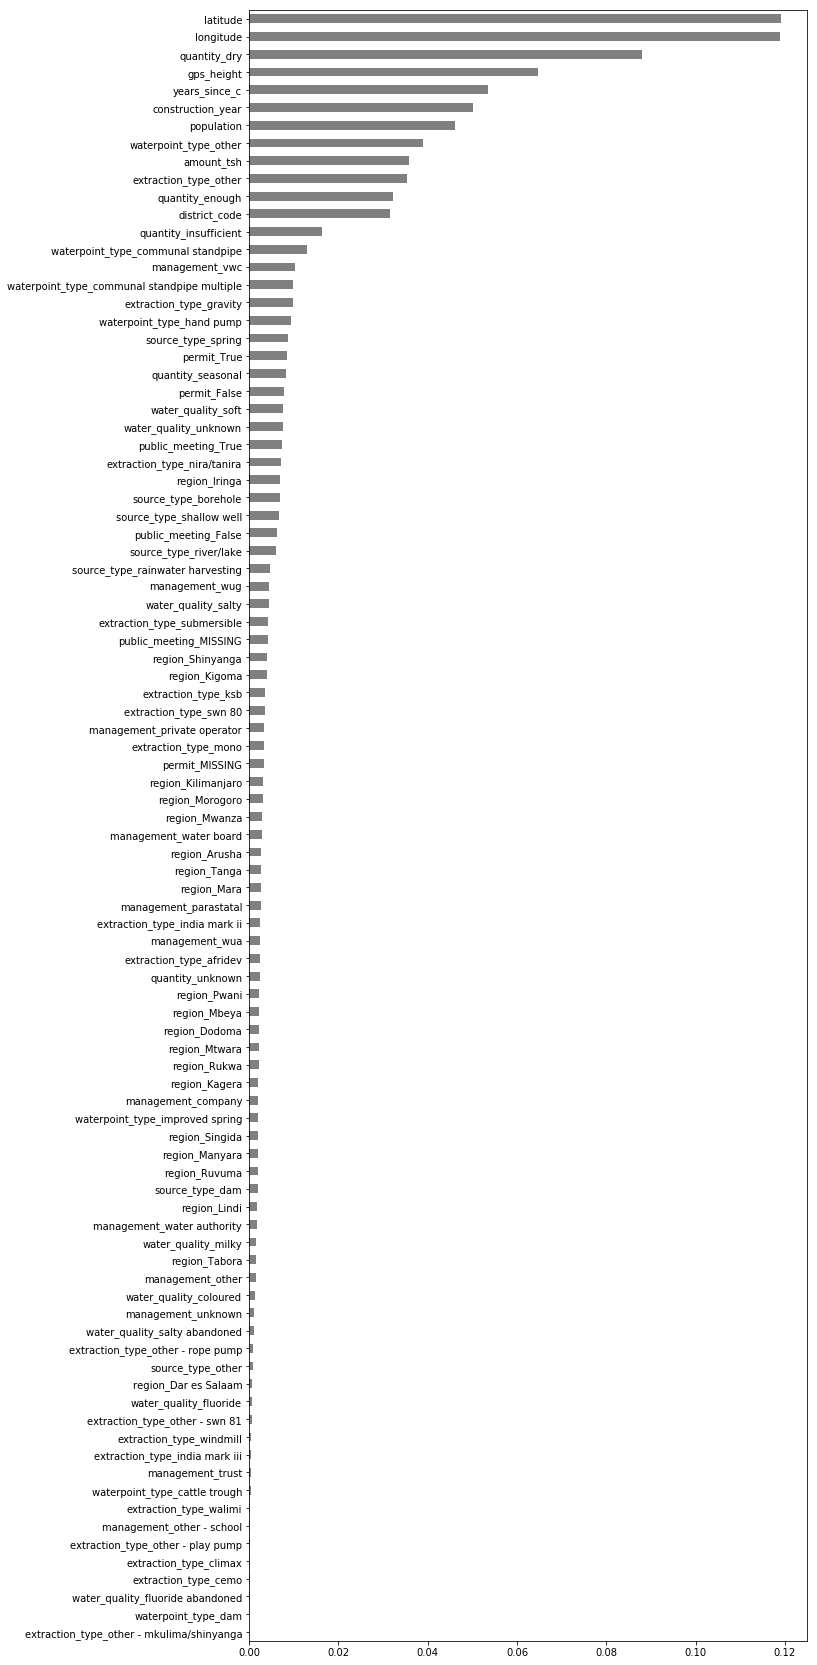

In [0]:
importances = pd.Series(model.feature_importances_, 
                        X_train_encoded.columns)

plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators = 444, random_state=42, max_depth = 232)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))


Validation Accuracy 0.8069023569023569


In [0]:
from ipywidgets import interact

feature1 = 'years_since_c'
feature2 = 'amount_tsh'
def viz2D(fitted_model, X, feature1, feature2, num=100, title=''):
    """
    Visualize model predictions as a 2D heatmap
    For regression or binary classification models, fitted on 2 features
    
    Parameters
    ----------
    fitted_model : scikit-learn model, already fitted
    X : pandas dataframe, which was used to fit model
    feature1 : string, name of feature 1
    feature2 : string, name of feature 2
    target : string, name of target
    num : int, number of grid points for each feature
    
    Returns
    -------
    predictions: numpy array, predictions/predicted probabilities at each grid point
    
    References
    ----------
    https://scikit-learn.org/stable/auto_examples/classification/plot_classification_probability.html
    https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
    """
    x1 = np.linspace(X[feature1].min(), X[feature1].max(), num)
    x2 = np.linspace(X[feature2].min(), X[feature2].max(), num)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.c_[X1.flatten(), X2.flatten()]
    if hasattr(fitted_model, 'predict_proba'):
        predicted = fitted_model.predict_proba(X)[:,0]
    else:
        predicted = fitted_model.predict(X)
    
    plt.imshow(predicted.reshape(num, num), cmap='viridis')
    plt.title(title)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()
    return predicted

def get_X_y(df, feature1, feature2, target):
    features = [feature1, feature2]
    X = df[features]
    y = df[target]
    X = X.fillna(X.median())
    X = ce.OrdinalEncoder().fit_transform(X)
    return X, y

def waterpumps_bagging(max_depth=1, n_estimators=1):
    predicteds = []
    for i in range(n_estimators):
        title = f'Tree {i+1}'
        bootstrap_sample = train2.sample(n=len(train2), replace=True)
        X, y = get_X_y(bootstrap_sample, feature1, feature2, target='status_group')
        tree = RandomForestClassifier(max_depth=max_depth)
        tree.fit(X, y)
        predicted = viz2D(tree, X, feature1, feature2, title=title)
        predicteds.append(predicted)
    
    ensembled = np.vstack(predicteds).mean(axis=0)
    title = f'Ensemble of {n_estimators} trees, with max_depth={max_depth}'
    plt.imshow(ensembled.reshape(100, 100), cmap='viridis')
    plt.title(title)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()
        
interact(waterpumps_bagging, max_depth=(1,6,1), n_estimators=(2,5,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=2, descriptio…

In [0]:
from sklearn.decomposition import PCA


In [0]:
categorical_features = [
 'region',
 'public_meeting',
 'permit',
 'extraction_type',
 'management',
 'water_quality',
 'quantity',
 'source_type',
 'waterpoint_type']
numeric_features = ['amount_tsh', 'latitude','longitude','population','construction_year','district_code','gps_height','years_since_c']
target = 'status_group'
features = numeric_features + categorical_features

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [0]:
# Arrange data into X features matrix and y target vector 
X_train_cat = train2[categorical_features]
X_train_num = train2[numeric_features]
y_train = train2[target]

X_val_cat = val2[categorical_features]
X_val_num = val2[numeric_features]
y_val = val2[target]

X_test_cat = test2[categorical_features]
X_test_num = test2[numeric_features]
X_test = test2[features]

pca = PCA()

scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train_num)
scaled_val = scaler.fit_transform(X_val_num)
scaled_test = scaler.fit_transform(X_test_num)

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = pd.concat([pd.DataFrame(pca.fit_transform(scaled_train)),encoder.fit_transform(X_train_cat)],axis=1, sort=False)
X_val_encoded = pd.concat([pd.DataFrame(pca.transform(scaled_val)),encoder.transform(X_val_cat)],axis=1, sort=False)
X_test_encoded = pd.concat([pd.DataFrame(pca.transform(scaled_test)),encoder.transform(X_test_cat)],axis=1, sort=False)

# pca = PCA()

# scaler = StandardScaler()
# scaled_train = scaler.fit_transform(X_train_num)
# scaled_val = scaler.fit_transform(X_val_num)
# scaled_test = scaler.fit_transform(X_test_num)

# X_train_encoded = pca.fit_transform(scaled_train)
# X_val_encoded = pca.transform(scaled_val)
# X_test_encoded = pca.transform(scaled_test)


model = RandomForestClassifier(n_estimators = 446, random_state=42, max_depth = 23)
model.fit(X_train_encoded, y_train)


ValueError: ignored

In [0]:
print('RandomForest')
print('Train Accuracy', model.score(X_train_encoded, y_train))
print('Validation Accuracy', model.score(X_val_encoded, y_val))

RandomForest
Train Accuracy 0.9508627946127947
Validation Accuracy 0.8093434343434344


In [0]:
X_train_encoded = pca.fit_transform(X_train_cat)
X_val_encoded = pca.transform(X_val_cat)
X_test_encoded = pca.transform(X_test_cat)